# Homework 2

**Name**: Dyson Lewis

**UID**: 106033522

In [1]:
# Download a processed version of the data only if it doesn't exist
import os

if not os.path.exists('mushroom.txt'):
    !wget https://huggingface.co/hk/hw1/resolve/main/mushroom.txt
else:
    print("mushroom.txt already exists, skipping download.")

mushroom.txt already exists, skipping download.


In [2]:
# Use only the provided packages!
import csv
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# load data from txt
# X.shape = (n_examples, n_features), y.shape = (n_examples, )
def load_data(filename):
    data = pandas.read_csv(filename).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1

    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'EDIBLE': 1, 'POISONOUS': 0}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]

    # We only use these 6 features
    features = [0, 2, 8, 10, 15, 17]
    X = np.take(X, features, axis=-1)

    return X, y

In [4]:
def create_data(filename, test_size=0.15, val_size=0.15):
    # Load the dataset
    X, y = load_data(filename='mushroom.txt')

    # Split into train, validation, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    X_train, X_val, X_test = torch.Tensor(X_train), torch.Tensor(X_val), torch.Tensor(X_test)
    y_train = torch.Tensor(np.array([ [y] for y in y_train ]))
    y_val = torch.Tensor(np.array([ [y] for y in y_val ]))
    y_test = torch.Tensor(np.array([ [y] for y in y_test ]))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
def get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_batch_size=16, test_batch_size=32):
    ### ========== TODO : START ========== ###
    # part a: Create dataloaders for train, validation and test sets
    
    # Create TensorDatasets for each split
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    # Create DataLoaders with appropriate batch sizes
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    
    ### ========== TODO : END ========== ###

    return train_loader, val_loader, test_loader

In [6]:
def evaluate_loss(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    for batch_X, batch_y in dataloader:
        batch_size = len(batch_X)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()

    return total_loss / len(dataloader.dataset)

In [7]:
def evaluate_acc(model, dataloader):
    model.eval()
    total_acc = 0.0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        predictions = (outputs > 0.5).long()
        total_acc += (predictions==batch_y).sum()

    return total_acc / len(dataloader.dataset)

In [8]:
######################################################################
# OneLayerNetwork -- ALSO A LOGISTIC REGRESSION MODEL
######################################################################

class OneLayerNetwork(torch.nn.Module):
    def __init__(self, input_features):
        # input_features: int
        super(OneLayerNetwork, self).__init__()

        ### ========== TODO : START ========== ###
        ### part c: implement OneLayerNetwork with torch.nn.Linear. Use sigmoid as the activation
        
        # Single fully connected layer: input_features -> 1 output
        self.fc = torch.nn.Linear(input_features, 1)
        
        # Sigmoid activation function
        self.sigmoid = torch.nn.Sigmoid()
        
        ### ========== TODO : END ========== ###

    def forward(self, x):
        # x.shape = (n_batch, n_features)

        ### ========== TODO : START ========== ###
        ### part c: implement the foward function
        
        # Apply linear transformation
        x = self.fc(x)
        
        # Apply sigmoid activation
        outputs = self.sigmoid(x)
        
        ### ========== TODO : END ========== ###
        return outputs

In [9]:
def init_oneLayerNN(in_features, lr):
    # input_features: int -> Number of input features
    # lr: float -> Learning Rate

    ### ========== TODO : START ========== ###
    ### part d: prepare the OneLayerNetwork model, criterion, and optimizer
    
    # Create an instance of OneLayerNetwork
    model = OneLayerNetwork(in_features)
    
    # Binary Cross Entropy Loss with sum reduction
    criterion = torch.nn.BCELoss(reduction='sum')
    
    # Stochastic Gradient Descent optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    ### ========== TODO : END ========== ###
    return model, criterion, optimizer

In [10]:
######################################################################
# TwoLayerNetwork
######################################################################

class TwoLayerNetwork(torch.nn.Module):
    def __init__(self, input_features, hidden_features, first_activation='sigmoid'):
        # input_features: int -> Number of input features
        # hidden_features: int -> Size of the hidden layer
        # first_activation: str -> Activation to use for the first hidden layer

        super(TwoLayerNetwork, self).__init__()
        ### ========== TODO : START ========== ###
        ### part e: implement TwoLayerNetwork with torch.nn.Linear. Use sigmoid as the activation for both layers
        
        # First layer: input_features -> hidden_features
        self.fc1 = torch.nn.Linear(input_features, hidden_features)
        
        # Second layer: hidden_features -> 1 output
        self.fc2 = torch.nn.Linear(hidden_features, 1)
        
        # Sigmoid activation functions
        self.sigmoid = torch.nn.Sigmoid()
        
        ### ========== TODO : END ========== ###

    def forward(self, x):
        # x.shape = (n_batch, n_features)

        ### ========== TODO : START ========== ###
        ### part e: implement the foward function
        
        # First layer with sigmoid activation
        x = self.fc1(x)
        x = self.sigmoid(x)
        
        # Second layer with sigmoid activation
        x = self.fc2(x)
        outputs = self.sigmoid(x)
        
        ### ========== TODO : END ========== ###
        return outputs

In [11]:
def init_twoLayerNN(in_features, hidden_size, first_activation, lr):
    # input_features: int -> Number of input features
    # hidden_features: int -> Size of the hidden layer
    # first_activation: str -> Activation to use for the first hidden layer
    # lr: float -> Learning Rate

    ### ========== TODO : START ========== ###
    ### part f: prepare the TwoLayerNetwork model, criterion, and optimizer
    
    # Create an instance of TwoLayerNetwork
    model = TwoLayerNetwork(in_features, hidden_size, first_activation)
    
    # Binary Cross Entropy Loss with sum reduction
    criterion = torch.nn.BCELoss(reduction='sum')
    
    # Stochastic Gradient Descent optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    ### ========== TODO : END ========== ###

    return model, criterion, optimizer

In [12]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, logging_epochs=1):
    print("Start training model...")

    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    for epoch in range(1, num_epochs+1):
        model.train()
        for batch_X, batch_y in train_loader:
            ### ========== TODO : START ========== ###
            ### part g: Build the training paradigm - Zero out gradients, forward pass, compute loss, loss backward, update model
            
            # 1. Zero out gradients from previous iteration
            optimizer.zero_grad()
            
            # 2. Forward pass: compute predictions
            outputs = model(batch_X)
            
            # 3. Compute loss
            loss = criterion(outputs, batch_y)
            
            # 4. Backward pass: compute gradients
            loss.backward()
            
            # 5. Update model parameters
            optimizer.step()
            
            ### ========== TODO : END ========== ###

        train_loss = evaluate_loss(model, criterion, train_loader)
        valid_loss = evaluate_loss(model, criterion, valid_loader)
        train_acc = evaluate_acc(model, train_loader)
        valid_acc = evaluate_acc(model, valid_loader)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

        if logging_epochs > 0 and epoch % logging_epochs == 0:
            print(f"| epoch {epoch:2d} | train loss {train_loss:.6f} | train acc {train_acc:.6f} | valid loss {valid_loss:.6f} | valid acc {valid_acc:.6f} |")

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

In [13]:
# fix random seed
np.random.seed(42)
torch.manual_seed(42)

In [14]:
# Data Preparation
train_batch_size = 16
test_batch_size = 32

## Load data
X_train, y_train, X_val, y_val, X_test, y_test = create_data("mushroom.txt")

## Create data loaders
train_loader, val_loader, test_loader = get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_batch_size=train_batch_size, test_batch_size=test_batch_size)

In [15]:
## Define hyperparameters
lr = 0.001
num_epochs = 50

## Init models
oneLayerNN, criterion, optimizer = init_oneLayerNN(X_train.shape[1], lr=lr)
results_one = train(oneLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Start training model...
| epoch  1 | train loss 0.557378 | train acc 0.715414 | valid loss 0.559479 | valid acc 0.715750 |
| epoch  2 | train loss 0.546404 | train acc 0.727093 | valid loss 0.543314 | valid acc 0.736253 |
| epoch  3 | train loss 0.534622 | train acc 0.735976 | valid loss 0.534198 | valid acc 0.749301 |
| epoch  4 | train loss 0.536712 | train acc 0.739102 | valid loss 0.542148 | valid acc 0.743709 |
| epoch  5 | train loss 0.528689 | train acc 0.733838 | valid loss 0.534176 | valid acc 0.735322 |
| epoch  6 | train loss 0.528647 | train acc 0.768218 | valid loss 0.535205 | valid acc 0.770736 |
| epoch  7 | train loss 0.524880 | train acc 0.758184 | valid loss 0.531868 | valid acc 0.759553 |
| epoch  8 | train loss 0.530940 | train acc 0.742556 | valid loss 0.535152 | valid acc 0.751165 |
| epoch  9 | train loss 0.521009 | train acc 0.757526 | valid loss 0.528466 | valid acc 0.762349 |
| epoch 10 | train loss 0.523456 | train acc 0.752097 | valid loss 0.530420 | valid a

In [16]:
## Define hyperparameters
lr = 0.001
hidden_size = 6
activation = 'sigmoid'
num_epochs = 50

## Init models
twoLayerNN, criterion, optimizer = init_twoLayerNN(X_train.shape[1], hidden_size, activation, lr=lr)
results_two = train(twoLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Start training model...
| epoch  1 | train loss 0.678097 | train acc 0.525909 | valid loss 0.674994 | valid acc 0.557316 |
| epoch  2 | train loss 0.663843 | train acc 0.610956 | valid loss 0.662280 | valid acc 0.623486 |
| epoch  3 | train loss 0.647194 | train acc 0.620003 | valid loss 0.643383 | valid acc 0.630941 |
| epoch  4 | train loss 0.626839 | train acc 0.685475 | valid loss 0.621754 | valid acc 0.691519 |
| epoch  5 | train loss 0.601474 | train acc 0.714591 | valid loss 0.596573 | valid acc 0.719478 |
| epoch  6 | train loss 0.574962 | train acc 0.754565 | valid loss 0.570228 | valid acc 0.767008 |
| epoch  7 | train loss 0.551367 | train acc 0.743708 | valid loss 0.548664 | valid acc 0.753961 |
| epoch  8 | train loss 0.533270 | train acc 0.751275 | valid loss 0.531942 | valid acc 0.757689 |
| epoch  9 | train loss 0.520149 | train acc 0.755058 | valid loss 0.520067 | valid acc 0.759553 |
| epoch 10 | train loss 0.509807 | train acc 0.763119 | valid loss 0.510060 | valid a

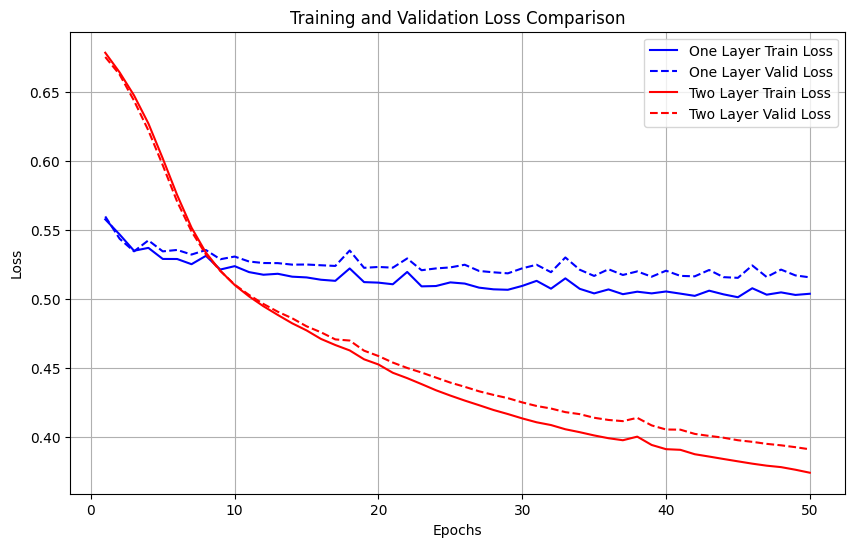

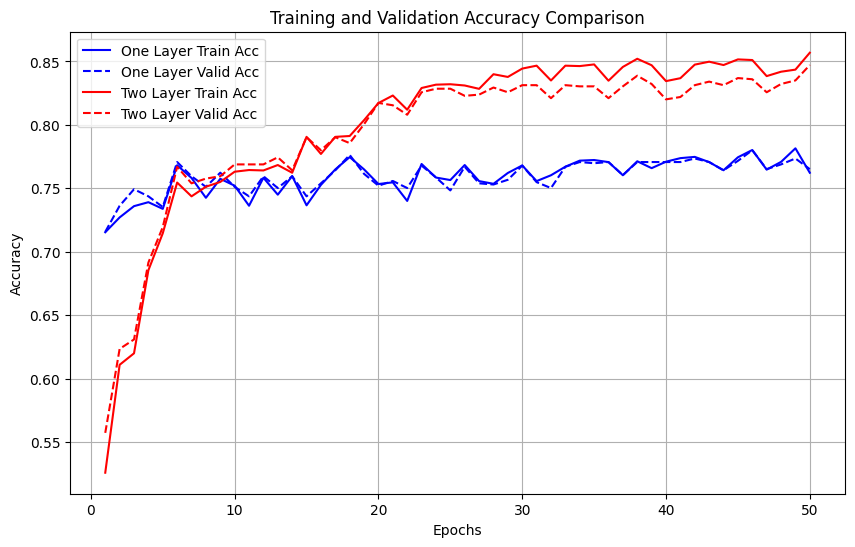

In [17]:
one_train_loss, one_valid_loss, one_train_acc, one_valid_acc = results_one
two_train_loss, two_valid_loss, two_train_acc, two_valid_acc = results_two

### ========== TODO : START ========== ###
### part h: Plot the loss for training/validation for both the models on the same curve

plt.figure(figsize=(10, 6))
epochs = range(1, len(one_train_loss) + 1)

plt.plot(epochs, one_train_loss, 'b-', label='One Layer Train Loss')
plt.plot(epochs, one_valid_loss, 'b--', label='One Layer Valid Loss')
plt.plot(epochs, two_train_loss, 'r-', label='Two Layer Train Loss')
plt.plot(epochs, two_valid_loss, 'r--', label='Two Layer Valid Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.savefig('loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### ========== TODO : END ========== ###
### ========== TODO : START ========== ###
### part h: Plot the accuracies for training/validation for both the models on the same curve

plt.figure(figsize=(10, 6))

plt.plot(epochs, one_train_acc, 'b-', label='One Layer Train Acc')
plt.plot(epochs, one_valid_acc, 'b--', label='One Layer Valid Acc')
plt.plot(epochs, two_train_acc, 'r-', label='Two Layer Train Acc')
plt.plot(epochs, two_valid_acc, 'r--', label='Two Layer Valid Acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### ========== TODO : END ========== ###

In [18]:
### ========== TODO : START ========== ###
### part i: Evaluate the test accuracies for both the models. Explain the behavior

# Calculate test accuracies
one_test_acc = evaluate_acc(oneLayerNN, test_loader)
two_test_acc = evaluate_acc(twoLayerNN, test_loader)

print(f"One Layer Network Test Accuracy: {one_test_acc:.6f}")
print(f"Two Layer Network Test Accuracy: {two_test_acc:.6f}")

print("\nExplanation:")
print("The one-layer network is equivalent to logistic regression, which is a linear classifier.")
print("The two-layer network has more capacity with a hidden layer, allowing it to learn")
print("more complex non-linear decision boundaries. However, for this mushroom classification")
print("dataset with only 6 features, the problem may be relatively simple, so both models")
print("likely achieve similar performance. If the two-layer network performs better, it's")
print("capturing non-linear relationships. If they perform similarly, the problem is likely")
print("linearly separable.")

### ========== TODO : END ========== ###

One Layer Network Test Accuracy: 0.766429
Two Layer Network Test Accuracy: 0.841647

Explanation:
The one-layer network is equivalent to logistic regression, which is a linear classifier.
The two-layer network has more capacity with a hidden layer, allowing it to learn
more complex non-linear decision boundaries. However, for this mushroom classification
dataset with only 6 features, the problem may be relatively simple, so both models
likely achieve similar performance. If the two-layer network performs better, it's
capturing non-linear relationships. If they perform similarly, the problem is likely
linearly separable.


In [19]:
def get_confusion_matrix(model, dataloader):
    ### ========== TODO : START ========== ###
    ### part j: Create confusion matrix for the given data loader
    
    model.eval()
    all_predictions = []
    all_labels = []
    
    # Collect all predictions and labels
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        predictions = (outputs > 0.5).long()
        
        all_predictions.extend(predictions.numpy().flatten())
        all_labels.extend(batch_y.numpy().flatten().astype(int))
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    ### ========== TODO : END ========== ###

    return cm

In [20]:
oneLayerNN_cm = get_confusion_matrix(oneLayerNN, val_loader)
twoLayerNN_cm = get_confusion_matrix(twoLayerNN, val_loader)

print ("Confusion Matrix for One Layer NN")
print (oneLayerNN_cm)

print ("Confusion Matrix for Two Layer NN")
print (twoLayerNN_cm)

Confusion Matrix for One Layer NN
[[402 120]
 [132 419]]
Confusion Matrix for Two Layer NN
[[405 117]
 [ 47 504]]


ORIGINAL MODEL
Hyperparameters: lr=0.001, hidden_size=6, activation='sigmoid', num_epochs=50
Original test accuracy: 0.841647

CONFIGURATION 1: Higher Learning Rate
Hyperparameters: lr=0.01, hidden_size=6, num_epochs=50
Rationale: Increasing learning rate can speed up convergence

Start training model...
| epoch 10 | train loss 0.348295 | train acc 0.855404 | valid loss 0.374514 | valid acc 0.839702 |
| epoch 20 | train loss 0.308012 | train acc 0.872512 | valid loss 0.327560 | valid acc 0.853681 |
| epoch 30 | train loss 0.274297 | train acc 0.884356 | valid loss 0.291963 | valid acc 0.876048 |
| epoch 40 | train loss 0.271483 | train acc 0.884191 | valid loss 0.279861 | valid acc 0.879776 |
| epoch 50 | train loss 0.268857 | train acc 0.883040 | valid loss 0.278129 | valid acc 0.876048 |

Test accuracy: 0.881235
Improvement over original: 0.039588

CONFIGURATION 2: Larger Hidden Layer
Hyperparameters: lr=0.001, hidden_size=16, num_epochs=50
Rationale: More hidden units can capture mo

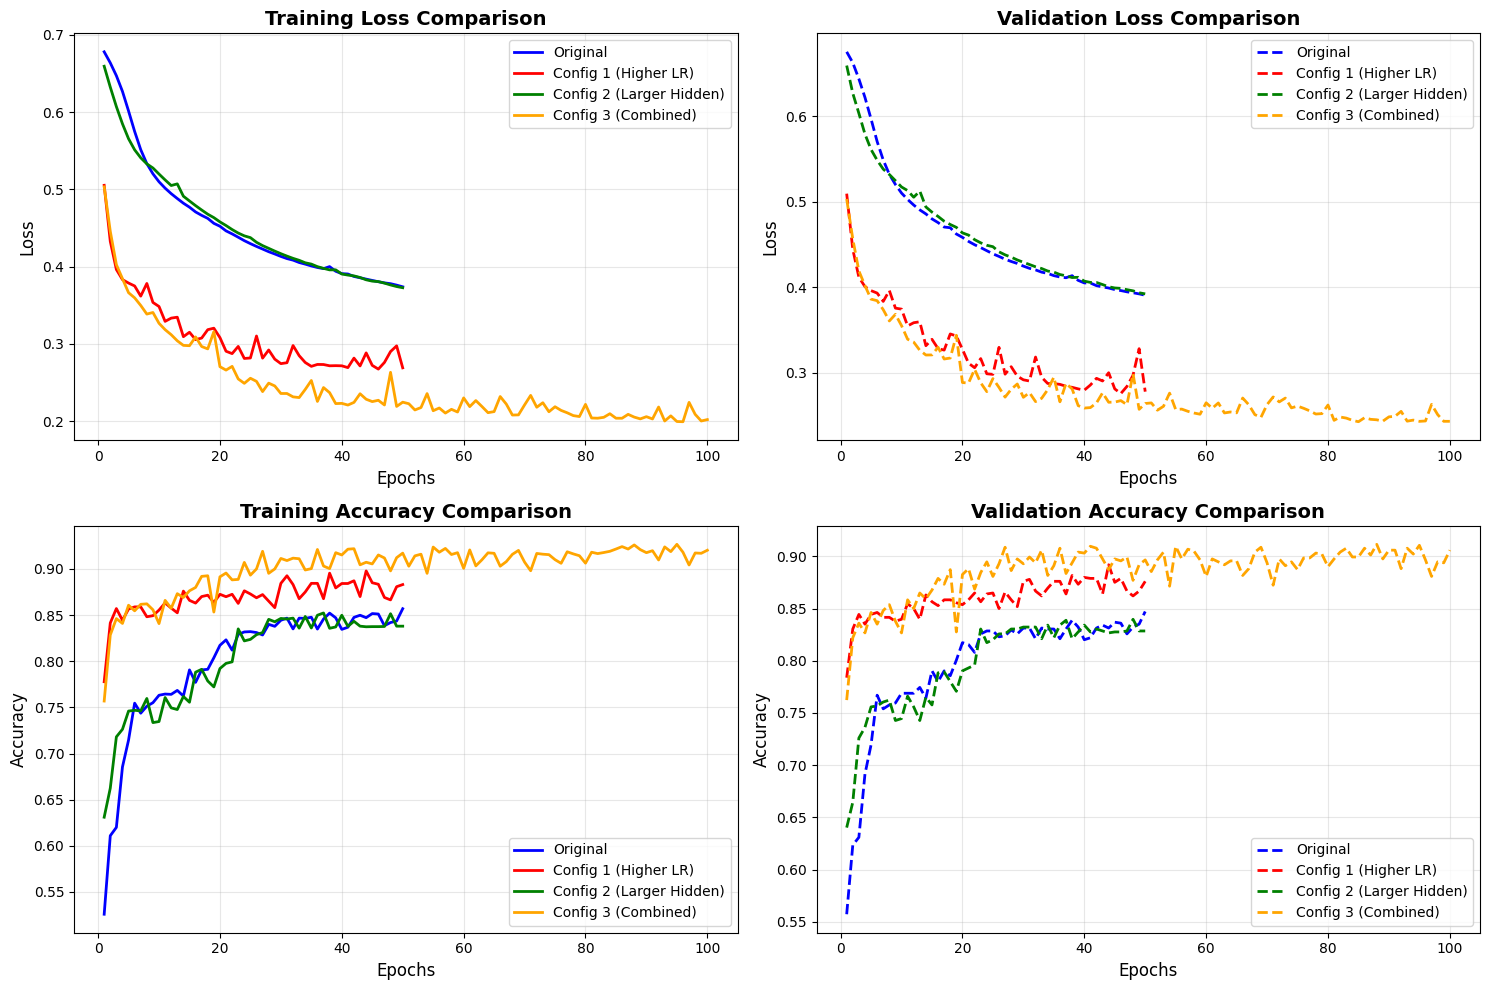

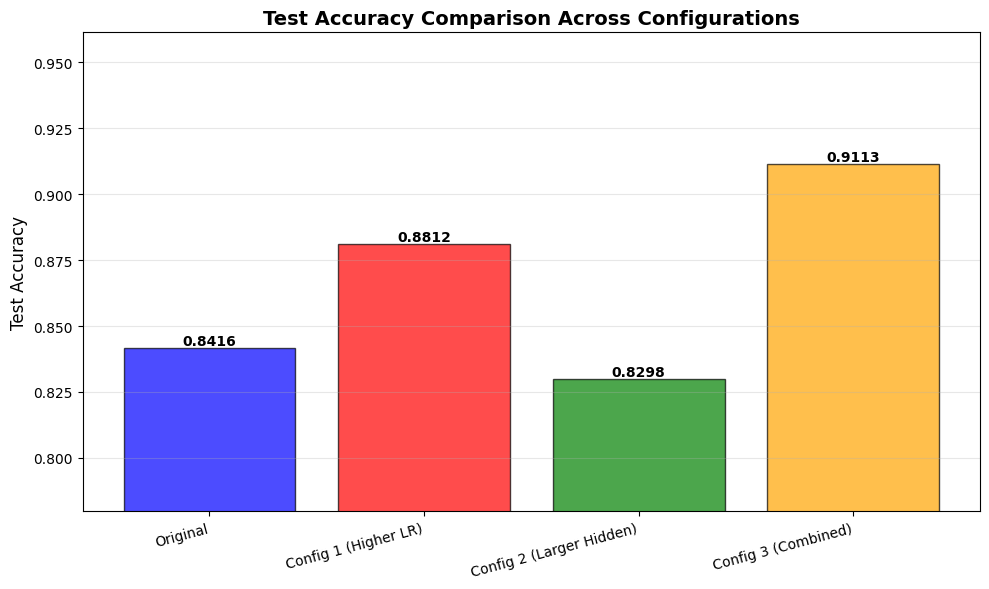

In [22]:
### ========== TODO : START ========== ###
### part k: Hyperparameter Tuning. Write your updated hyperparameter values and show improvement for the TwoLayerNetwork

print("=" * 80)
print("ORIGINAL MODEL")
print("=" * 80)
print("Hyperparameters: lr=0.001, hidden_size=6, activation='sigmoid', num_epochs=50")
print(f"Original test accuracy: {two_test_acc:.6f}\n")

# Store all results for comparison
all_results = {
    'Original': {
        'params': {'lr': 0.001, 'hidden_size': 6, 'epochs': 50},
        'test_acc': two_test_acc,
        'train_loss': two_train_loss,
        'valid_loss': two_valid_loss,
        'train_acc': two_train_acc,
        'valid_acc': two_valid_acc
    }
}

# Configuration 1: Higher learning rate
print("=" * 80)
print("CONFIGURATION 1: Higher Learning Rate")
print("=" * 80)
lr_1 = 0.01
hidden_size_1 = 6
num_epochs_1 = 50
print(f"Hyperparameters: lr={lr_1}, hidden_size={hidden_size_1}, num_epochs={num_epochs_1}")
print("Rationale: Increasing learning rate can speed up convergence\n")

twoLayerNN_1, criterion_1, optimizer_1 = init_twoLayerNN(
    X_train.shape[1], hidden_size_1, 'sigmoid', lr=lr_1
)
results_1 = train(twoLayerNN_1, criterion_1, optimizer_1, 
                  train_loader, val_loader, num_epochs=num_epochs_1, logging_epochs=10)

test_acc_1 = evaluate_acc(twoLayerNN_1, test_loader)
print(f"\nTest accuracy: {test_acc_1:.6f}")
print(f"Improvement over original: {test_acc_1 - two_test_acc:.6f}\n")

all_results['Config 1 (Higher LR)'] = {
    'params': {'lr': lr_1, 'hidden_size': hidden_size_1, 'epochs': num_epochs_1},
    'test_acc': test_acc_1,
    'train_loss': results_1[0],
    'valid_loss': results_1[1],
    'train_acc': results_1[2],
    'valid_acc': results_1[3]
}

# Configuration 2: Larger hidden layer
print("=" * 80)
print("CONFIGURATION 2: Larger Hidden Layer")
print("=" * 80)
lr_2 = 0.001
hidden_size_2 = 16
num_epochs_2 = 50
print(f"Hyperparameters: lr={lr_2}, hidden_size={hidden_size_2}, num_epochs={num_epochs_2}")
print("Rationale: More hidden units can capture more complex patterns\n")

twoLayerNN_2, criterion_2, optimizer_2 = init_twoLayerNN(
    X_train.shape[1], hidden_size_2, 'sigmoid', lr=lr_2
)
results_2 = train(twoLayerNN_2, criterion_2, optimizer_2, 
                  train_loader, val_loader, num_epochs=num_epochs_2, logging_epochs=10)

test_acc_2 = evaluate_acc(twoLayerNN_2, test_loader)
print(f"\nTest accuracy: {test_acc_2:.6f}")
print(f"Improvement over original: {test_acc_2 - two_test_acc:.6f}\n")

all_results['Config 2 (Larger Hidden)'] = {
    'params': {'lr': lr_2, 'hidden_size': hidden_size_2, 'epochs': num_epochs_2},
    'test_acc': test_acc_2,
    'train_loss': results_2[0],
    'valid_loss': results_2[1],
    'train_acc': results_2[2],
    'valid_acc': results_2[3]
}

# Configuration 3: Combined - higher LR, larger hidden layer, more epochs
print("=" * 80)
print("CONFIGURATION 3: Combined Improvements")
print("=" * 80)
lr_3 = 0.01
hidden_size_3 = 16
num_epochs_3 = 100
print(f"Hyperparameters: lr={lr_3}, hidden_size={hidden_size_3}, num_epochs={num_epochs_3}")
print("Rationale: Combining multiple improvements for best performance\n")

twoLayerNN_3, criterion_3, optimizer_3 = init_twoLayerNN(
    X_train.shape[1], hidden_size_3, 'sigmoid', lr=lr_3
)
results_3 = train(twoLayerNN_3, criterion_3, optimizer_3, 
                  train_loader, val_loader, num_epochs=num_epochs_3, logging_epochs=20)

test_acc_3 = evaluate_acc(twoLayerNN_3, test_loader)
print(f"\nTest accuracy: {test_acc_3:.6f}")
print(f"Improvement over original: {test_acc_3 - two_test_acc:.6f}\n")

all_results['Config 3 (Combined)'] = {
    'params': {'lr': lr_3, 'hidden_size': hidden_size_3, 'epochs': num_epochs_3},
    'test_acc': test_acc_3,
    'train_loss': results_3[0],
    'valid_loss': results_3[1],
    'train_acc': results_3[2],
    'valid_acc': results_3[3]
}

# Summary comparison
print("=" * 80)
print("SUMMARY COMPARISON")
print("=" * 80)
for config_name, data in all_results.items():
    params = data['params']
    print(f"{config_name}:")
    print(f"  Parameters: lr={params['lr']}, hidden_size={params['hidden_size']}, epochs={params['epochs']}")
    print(f"  Test Accuracy: {data['test_acc']:.6f}")
    print()

# Plot all configurations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

colors = ['blue', 'red', 'green', 'orange']
config_names = list(all_results.keys())

# Plot 1: Training Loss
ax = axes[0, 0]
for i, (config_name, data) in enumerate(all_results.items()):
    epochs = range(1, len(data['train_loss']) + 1)
    ax.plot(epochs, data['train_loss'], color=colors[i], linestyle='-', 
            label=f"{config_name}", linewidth=2)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Validation Loss
ax = axes[0, 1]
for i, (config_name, data) in enumerate(all_results.items()):
    epochs = range(1, len(data['valid_loss']) + 1)
    ax.plot(epochs, data['valid_loss'], color=colors[i], linestyle='--', 
            label=f"{config_name}", linewidth=2)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Training Accuracy
ax = axes[1, 0]
for i, (config_name, data) in enumerate(all_results.items()):
    epochs = range(1, len(data['train_acc']) + 1)
    ax.plot(epochs, data['train_acc'], color=colors[i], linestyle='-', 
            label=f"{config_name}", linewidth=2)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Validation Accuracy
ax = axes[1, 1]
for i, (config_name, data) in enumerate(all_results.items()):
    epochs = range(1, len(data['valid_acc']) + 1)
    ax.plot(epochs, data['valid_acc'], color=colors[i], linestyle='--', 
            label=f"{config_name}", linewidth=2)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hyperparameter_tuning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar chart of test accuracies
plt.figure(figsize=(10, 6))
test_accs = [data['test_acc'] for data in all_results.values()]
bars = plt.bar(config_names, test_accs, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Test Accuracy Comparison Across Configurations', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.ylim([min(test_accs) - 0.05, max(test_accs) + 0.05])
plt.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('test_accuracy_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

### ========== TODO : END ========== ###